# Backtesting

In this section, we construct a backtest using industry data. More precisely, we use data from Ken French's data library to construct a simple industry momentum return predictor.

The goal of a backtest is to assess the validity of a trading predictor at any point in the past. In particular, it is crucial to avoid any forward-looking bias -- in which information available only after time $t$ is mistakingly used at time $t$. In practice, the predictors are estimated over `rolling` (or `expanding`) windows. We implement rolling window estimation with the `sklearn` `TimeSeriesSplit` object. 

For backtesting, visualisation is very important and we make use of some plotting functions introduced in the Appendix:

In [1]:
from ml4pmt.plot import line, bar, heatmap

## Markowitz portfolio optimisation

First: a review of mean-variance optimisation for a universe with $N$ assets: $\alpha$ is the return forecast: $\alpha = E(r)$.


**Lemma** [mean-variance]: the allocation that maximizes the utility $h^T \alpha - \frac{h^T V h}{2 \lambda}$ is
$$h = \lambda V^{-1} \alpha $$,  
where $\lambda$ is the risk-tolerance.

The ex-ante risk is $h^T V h = \lambda^2 \alpha^T V^{-1} \alpha$ and the ex-ante Sharpe ratio is
$$
S = \frac{h^T E(r)}{\sqrt{h^T V h}} = \sqrt{\alpha^T V^{-1} \alpha}. 
$$

**Corollary**: The maximisation of the sharpe ratio is equivalent (up to a scaling factor) the mean-variance optimisation. 

The mean-variance formula is extended to account for the linear constraints
$$A h = b. $$ 

To do so, we introduce the Lagrangian $\mathcal {L}$ (and Lagrange multiplier $\xi$)

$$
\mathcal {L}= h^T \alpha - \frac{h^T V h}{2\lambda} - (h^T A^T - b^T)\xi
$$

The Lagrange multiplier $\xi$ is a `tuning parameter` chosen exactly so that the constraint above holds. At the optimal value of $\xi$, the constrained problem boils down to an unconstrained problem with the adjusted return forecast $\alpha - A^T \xi$.


**Lemma**: the allocation that maximizes the utility $h^T \alpha - \frac{h^T V h}{2 \lambda}$ under the linear constraint $A h = b$ is

$$ h = V^{-1} A^T \left(A V^{-1} A^T \right)^{-1} b + \lambda V^{-1} \left[\alpha - A^T \left(A V^{-1} A^T \right)^{-1} A V^{-1} \alpha \right]$$

*Proof*: the first-order condition is

$$ \frac{\partial \mathcal {L}}{\partial h} = \alpha - \frac{V h}{\lambda} - A^T \xi =0  \Leftrightarrow  h = \lambda V^{-1}[\alpha - A^T \xi] $$

The parameter $\xi$ is chosen that $A h = b$

$$b = Ah = \lambda A  V^{-1}[\alpha - A^T \xi]  \Rightarrow  \xi = [A V^{-1}A^T]^{-1} \left[ A  V^{-1}\alpha - \frac{b}{\lambda}  \right]
$$

The holding vector under constraint is

$$ h_{\lambda} = \underbrace {V^{-1} A^T \left(A V^{-1} A^T \right)^{-1} b}_{\text {minimum variance portfolio}} + \underbrace { \lambda V^{-1} \left[\alpha - A^T \left(A V^{-1} A^T \right)^{-1} A V^{-1} \alpha \right]}_{\text {speculative portfolio}} $$

- The first term is what minimises the risk $h^T V h$ under the constraint $Ah =b$ (in particular, it does not depend on expected returns or risk-tolerance).

- The second term is the speculative portfolio (it is sensitive to both inputs).

The efficient frontier is the relation between  expected portfolio return $h^T \alpha$ and portfolio standard deviation $\sqrt{h^T V h}$ for varying level of risk-tolerance
$$ (x, y) \mapsto \left(h_{\lambda}^T \alpha, \sqrt{h_{\lambda}^T V h_{\lambda}} \right)$$

When $b=0$, the efficient frontier between $h_{\lambda}^T \alpha$ and $\sqrt{h_{\lambda}^T V h_{\lambda}}$ is a line through $(0,0)$; otherwise, it is a parabolic curve.

We focus on pure "alpha views" -- that is, long-short "cash-neutral" portfolios where the sum of holdings is zero. In this case $b=0$ and $A = \textbf{1}$ where

$$ \textbf {1} = \left[\begin {array}{ccc} 1  & \ldots & 1  \end {array} \right].$$

## Industry momentum backtest 

The setup for predicting industry returns is the following: 

- the assets are industries; 

- the return forecast $\alpha$ is estimated using rolling-window returns (over $L$ months, $L=12$) preceding a given date; 

-  no `look-ahead bias`: at each date, only information up that date is used; 

- such a strategy goes long past "winners" (industries with higher-than-average returns) and goes short "losers" (industries with lower-than-average returns) $\Rightarrow$ Momentum strategy; 

- this strategy is often implemented by skipping the most recent month to avoid the `1-month reversal" effect`. 

See Moskowitz and Grinblatt (1999): "Do Industries Explain Momentum,"  *Journal of Finance*

In [2]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from IPython.display import display, Image

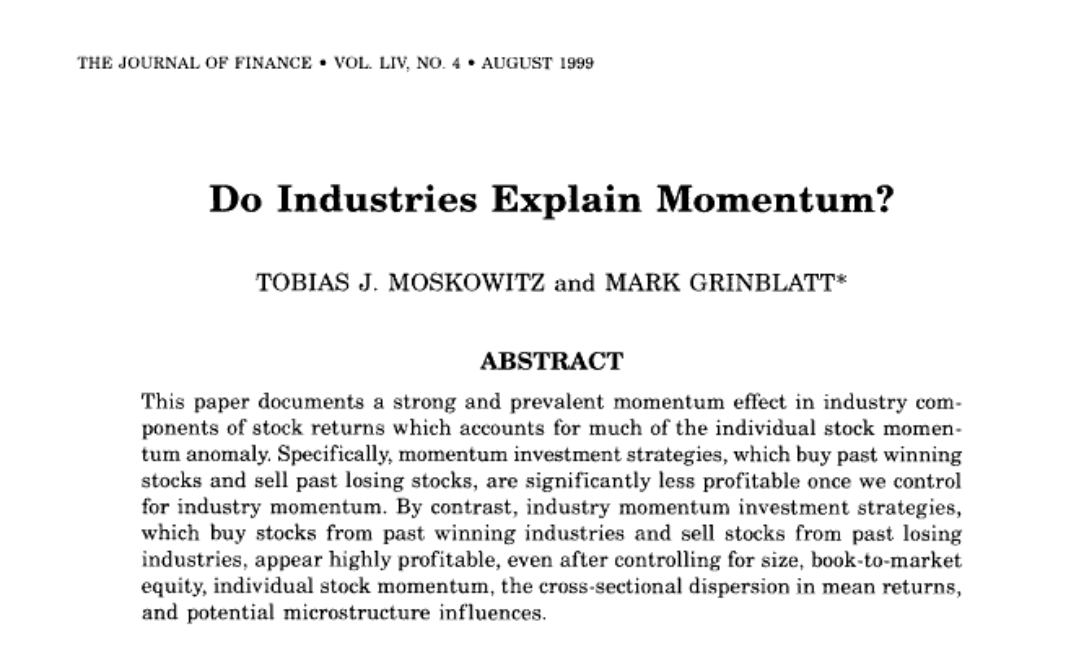

In [3]:
#hide 
display(Image("images/l2_grinblatt_header.png"))

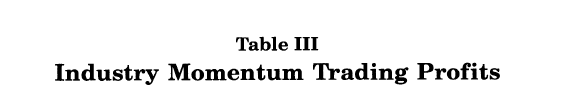

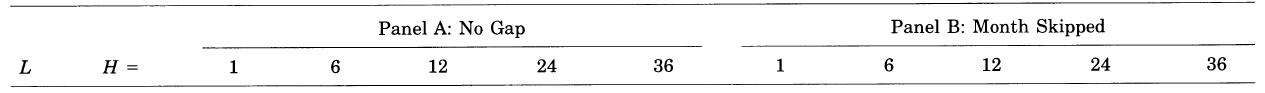

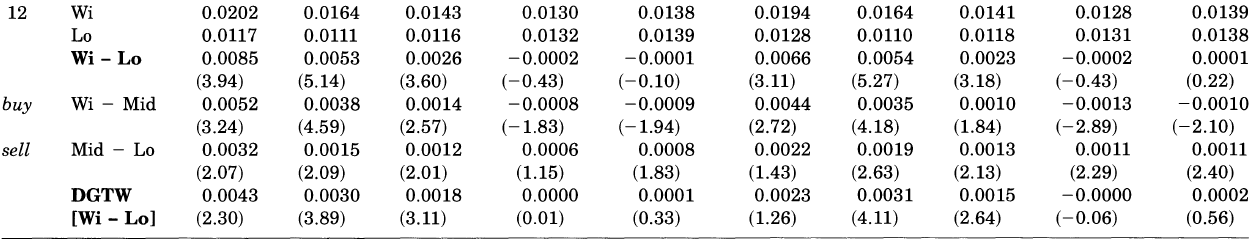

In [4]:
#hide
display(Image("images/l2_grinblatt_table3heading.PNG"))
display(Image("images/l2_grinblatt_table3heading2.PNG"))
display(Image("images/l2_grinblatt_table3.PNG"))

### Industry data

In [5]:
from ml4pmt.dataset import load_kf_returns

In [6]:
returns_data = load_kf_returns(cache_dir="data", force_reload=True)

INFO:ml4pmt.dataset:loading from external source
INFO:ml4pmt.dataset:saving in cache directory data/12_Industry_Portfolios


Since the Moskowitz-Grinblatt paper was published in August 1999, we will keep the data after 1999 as `out-of-sample` and only use the data before 1999. 

In [7]:
ret = returns_data["Monthly"]["Average_Value_Weighted_Returns"][:'1999']

Time convention:
- holdings $h_t$ and returns $r_t$ are known for period $t$ -- ie. *at the end of period $t$.

- so to compute pnl with forward-looking information, the holdings must only depend on information up to $t-1$

- in practice, we will have

$$ pnl_t = h_{t-1} \times r_t $$

### Backtesting functions

In the next set of helper file, we introduce three main functions: 

- a function that computes mean-variance holdings for batches

- a `MeanVariance` class that follows the `sklearn` api

- a `fit_and_predict` function to run rolling window estimations. 

In [8]:
%%writefile ../ml4pmt/backtesting.py
from sklearn.utils.metaestimators import _safe_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import BaseEstimator, clone
from ml4pmt.metrics import sharpe_ratio
from joblib import Parallel, delayed
import pandas as pd
import numpy as np


def compute_batch_holdings(pred, V, A=None, past_h=None, constant_risk=False):
    """
    compute markowitz holdings with return prediction "mu" and covariance matrix "V"

    mu: numpy array (shape N * K)
    V: numpy array (N * N)

    """

    N, _ = V.shape
    if isinstance(pred, pd.Series) | isinstance(pred, pd.DataFrame):
        pred = pred.values
    if pred.shape == (N,):
        pred = pred[:, None]
    elif pred.shape[1] == N:
        pred = pred.T

    invV = np.linalg.inv(V)
    if A is None:
        M = invV
    else:
        U = invV.dot(A)
        if A.ndim == 1:
            M = invV - np.outer(U, U.T) / U.dot(A)
        else:
            M = invV - U.dot(np.linalg.inv(U.T.dot(A)).dot(U.T))
    h = M.dot(pred)
    if constant_risk:
        h = h / np.sqrt(np.diag(h.T.dot(V.dot(h))))
    return h.T


class MeanVariance(BaseEstimator):
    def __init__(self, transform_V=None, A=None, constant_risk=True):

        if transform_V is None:
            self.transform_V = lambda x: np.cov(x.T)
        else:
            self.transform_V = transform_V
        self.A = A
        self.constant_risk = constant_risk

    def fit(self, X, y=None):
        self.V_ = self.transform_V(y)

    def predict(self, X):
        if self.A is None:
            T, N = X.shape
            A = np.ones(N)
        else:
            A = self.A
        h = compute_batch_holdings(
            X, self.V_, A, constant_risk=self.constant_risk)
        return h

    def score(self, X, y):
        return sharpe_ratio(np.sum(X * y, axis=1))


class Backtester:
    def __init__(
        self,
        estimator,
        ret,
        max_train_size=36,
        test_size=1,
        start_date="1945-01-01",
        end_date=None,
    ):

        self.start_date = start_date
        self.end_date = end_date
        self.estimator = estimator
        self.ret = ret[: self.end_date]
        self.cv = TimeSeriesSplit(
            max_train_size=max_train_size,
            test_size=test_size,
            n_splits=1 + len(ret.loc[start_date:end_date]) // test_size,
        )

    def train(self, features, target):
        pred, estimators = fit_predict(
            self.estimator, features, target, self.ret, self.cv, return_estimator=True
        )
        self.estimators_ = estimators
        self.h_ = pred
        self.pnl_ = (
            pred.shift(1).mul(self.ret).sum(axis=1)[
                self.start_date: self.end_date]
        )
        return self


def _fit_predict(estimator, X, y, train, test, return_estimator=False):
    X_train, y_train = _safe_split(estimator, X, y, train)
    X_test, _ = _safe_split(estimator, X, y, test, train)
    estimator.fit(X_train, y_train)
    if return_estimator:
        return estimator.predict(X_test), estimator
    else:
        return estimator.predict(X_test)


def fit_predict(
    estimator,
    features,
    target,
    ret,
    cv,
    return_estimator=False,
    verbose=0,
    pre_dispatch="2*n_jobs",
    n_jobs=1,
):
    parallel = Parallel(n_jobs=n_jobs, verbose=verbose,
                        pre_dispatch=pre_dispatch)
    res = parallel(
        delayed(_fit_predict)(
            clone(estimator), features, target, train, test, return_estimator
        )
        for train, test in cv.split(ret)
    )
    if return_estimator:
        pred, estimators = zip(*res)
    else:
        pred = res
    cols = ret.columns
    idx = ret.index[np.concatenate([test for _, test in cv.split(ret)])]
    if return_estimator:
        return pd.DataFrame(np.concatenate(pred), index=idx, columns=cols), estimators
    else:
        return pd.DataFrame(np.concatenate(pred), index=idx, columns=cols)

Overwriting ../ml4pmt/backtesting.py


In [9]:
from ml4pmt.backtesting import compute_batch_holdings, MeanVariance, Backtester

In [10]:
T, N = ret.shape
A = np.ones(N)

In [11]:
h = compute_batch_holdings(ret.mean(), ret.cov(), A, past_h=None)

In [12]:
np.allclose(h.dot(A), [0.])

True

In [13]:
A = np.stack([np.ones(N), np.zeros(N)], axis=1)
A[0, 1] = 1

In [14]:
h = compute_batch_holdings(pred=ret.mean(), V=ret.cov(), A=A, past_h=None)

In [15]:
np.allclose(h.dot(A), [0., 0.])

True

### Scikit-Learn TimeSeriesSplit

In [16]:
from sklearn.model_selection import TimeSeriesSplit

Given that the data is monthly, we re-estimate the model every month. This is done by choosing the parameter `n_splits` in the class `TimeSeriesSplit` as the number of months. 

In [17]:
start_date = "1945-01-01"
test_size = 1
params = dict(max_train_size=36, test_size=test_size, gap=0)
params["n_splits"] = 1 + len(ret.loc[start_date:]) // test_size

cv = TimeSeriesSplit(**params)

More precisely, with `TimeSeriesSplit`:

- the `test` indices are the dates for which the holdings are computed.

- the `train` indices are the date range over which a forecasting model is trained.

- the target will been shifted by $-1$ and `gap` is set to 0. 

- we can estimate batches with `test_size` > 1.

- `n_splits` is determined so that the backtest starts (just) before a certain start date.

In [18]:
for train, test in cv.split(ret):
    break
ret.iloc[train].index[-1], ret.iloc[test].index[0]

(Timestamp('1944-11-01 00:00:00'), Timestamp('1944-12-01 00:00:00'))

## Empiricial results

### Cumulative pnl

In [19]:
transform_X = lambda x: x.rolling(12).mean().values
transform_y = lambda x: x.shift(-1).values
features = transform_X(ret)
target = transform_y(ret)

In [20]:
_h = []
for train, test in cv.split(ret): 
    m = MeanVariance()
    m.fit(features[train], target[train])
    _h += [m.predict(features[test])]
    
cols = ret.columns 
idx = ret.index[np.concatenate([test for _, test in cv.split(ret)])]
h = pd.DataFrame(np.concatenate(_h), index=idx, columns=cols)

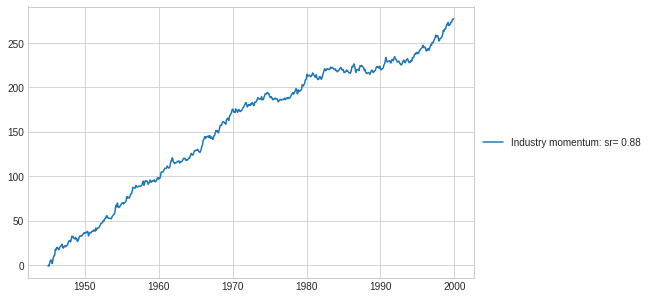

In [21]:
pnl = h.shift(1).mul(ret).sum(axis=1)[start_date:]
line(pnl.rename('Industry momentum'), cumsum=True)

In [22]:
m = Backtester(estimator=MeanVariance(), ret=ret)
m.train(features, target)
h.equals(m.h_), pnl.equals(m.pnl_)

(True, True)

### Other backtest statistics 

We can also extract information for the estimator -- e.g. in this simple case, recover the covariance matrix fitted by the class `MeanVariance()`.

In [23]:
estimators = m.estimators_

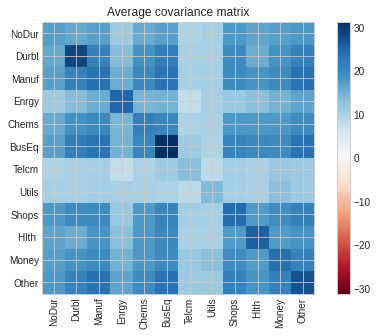

In [24]:
V_mean = pd.DataFrame(sum([m.V_ for m in estimators])/len(estimators), ret.columns, ret.columns)
heatmap(V_mean, title='Average covariance matrix')

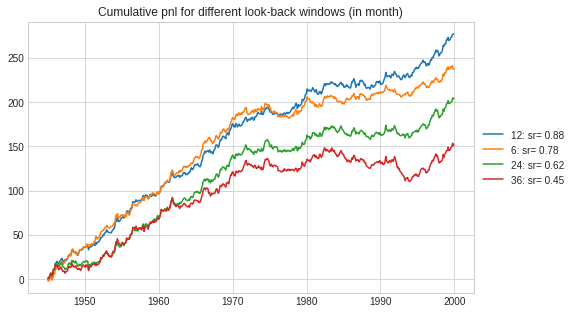

In [25]:
m = Backtester(estimator=MeanVariance(), ret=ret)
pnls = {}
for window in [6, 12, 24, 36]: 
    features_ = ret.rolling(window).mean().values
    m.train(features_, target)
    pnls[window] = m.pnl_
line(pnls, cumsum=True, start_date='1945', title='Cumulative pnl for different look-back windows (in month)')

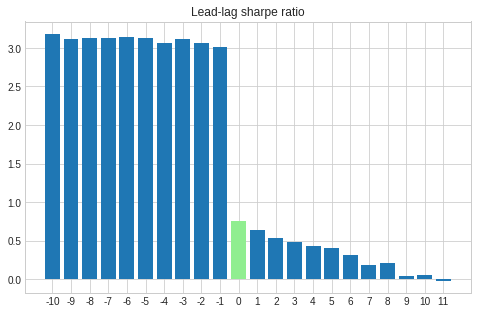

In [26]:
from ml4pmt.metrics import sharpe_ratio
sr = {i: h.shift(1+i).mul(ret).sum(axis=1).pipe(sharpe_ratio) for i in range(-10, 12)}
bar(sr, baseline=0, sort=False, title='Lead-lag sharpe ratio')

The `off-the-top` approach is to remove an asset from the tradable set and check whether the portfolio sharpe ratio decreases (in which case, this asset is a *contributor*) or increases (in which case, this asset is a *detractor*).

In [27]:
pnls_ott = {}
for c in ret.columns:
    ret_ = ret.drop(c, axis=1)
    features_ = transform_X(ret_)
    target_ = transform_y(ret_)
    pnl_ = Backtester(estimator=MeanVariance(), ret=ret_).train(features_, target_).pnl_
    pnls_ott[c] = pnl_.pipe(sharpe_ratio)

pnls_ott["ALL"] = pnl.pipe(sharpe_ratio)

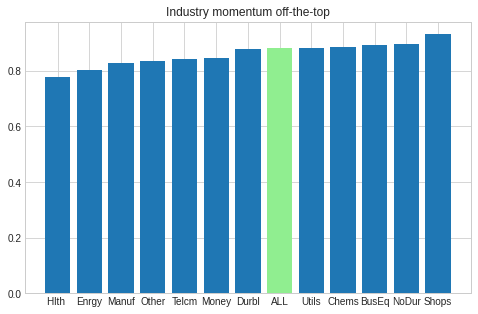

In [28]:
bar(pnls_ott, baseline="ALL", title='Industry momentum off-the-top')